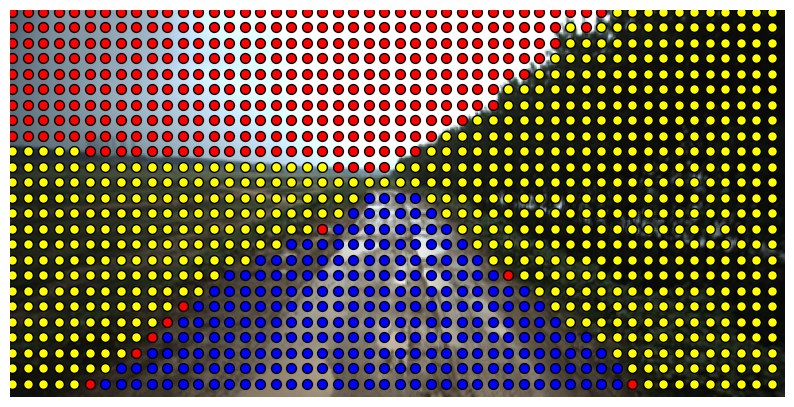

Data saved to ./RGB_data/UniformSampler_1066_3x3_multi_labelme.csv.
Image with sampled points saved to ./Sampled_Points_IMG/sampled_points_1066.png.


In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

# 选择图片和标签数据
target = 3
data_name = ['0618', '0854', '1066'][target - 1]
img_path = f'./input_data/{data_name}.png'  # 原图路径
json_path = f'./input_data/{data_name}.json'  # Labelme 标注文件路径
output_filename = f'./RGB_data/UniformSampler_{data_name}_3x3_multi_labelme.csv'  # 数据输出路径
output_img_path = f'./Sampled_Points_IMG/sampled_points_{data_name}.png'  # 保存带采样点的图像路径

# 加载原图
img = cv2.imread(img_path)

# 读取 Labelme JSON 数据
with open(json_path) as f:
    label_data = json.load(f)

# 创建空的标签图
height, width, _ = img.shape
label_img = np.zeros((height, width), dtype=np.uint8)

# 根据多边形标注生成标签图
for shape in label_data['shapes']:
    label = shape['label']
    points = np.array(shape['points'], dtype=np.int32)
    if label == 'road':
        cv2.fillPoly(label_img, [points], 255)  # 道路: road
    elif label == 'other':
        cv2.fillPoly(label_img, [points], 0)   # 其他: other 
    elif label == 'bg':
        cv2.fillPoly(label_img, [points], 128)    # 主背景: bg

# 确定采样步长
step_size = 10  # 增大步长以减少采样点数量

# 数据暂存
features = []
labels = []
sampling_points = []

# 进行均匀采样
for y in range(1, height - 1, step_size):
    for x in range(1, width - 1, step_size):
        # 提取3x3区域的BGR值
        feature_vector = img[y-1:y+2, x-1:x+2].flatten()  # 3x3平铺
        features.append(feature_vector)

        # 根据标签图确定标签
        label_value = label_img[y, x]
        if label_value == 255:  # road
            labels.append(1)
        elif label_value == 0:  # other
            labels.append(2)
        else:
            labels.append(0)  # background
        
        # 记录采样点位置
        sampling_points.append((x, y))

# 转换为NumPy数组
features_array = np.array(features)
labels_array = np.array(labels)

# 保存数据到CSV文件
df = pd.DataFrame(features_array, columns=[f'R_{i//3 + 1}_{i%3 + 1}' if i % 3 == 0 else f'G_{i//3 + 1}_{i%3 + 1}' if i % 3 == 1 else f'B_{i//3 + 1}_{i%3 + 1}' for i in range(27)])
df['Label'] = labels_array
df.to_csv(output_filename, index=False)

# 画图显示结果
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # 转换BGR为RGB

# 为不同标签的采样点设置不同颜色
color_map = {0: 'yellow', 1: 'blue', 2: 'red'}  # bg为黄，road为蓝，other为红
for (x, y), label in zip(sampling_points, labels):
    plt.scatter(x, y, c=color_map.get(label, 'yellow'), s=50, edgecolors='black')  # 用黑色边缘标记采样点

plt.title('')
plt.axis('off')  # 关闭坐标轴

# 保存带有采样点的图像
plt.savefig(output_img_path, bbox_inches='tight', pad_inches=0.1)
plt.show()

print(f"Data saved to {output_filename}.")
print(f"Image with sampled points saved to {output_img_path}.")
